<a href="https://colab.research.google.com/github/profsuccodifrutta/ai_act_RAG_navigator/blob/main/ai_act_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CREATION OF ENVIORMENT**

In [1]:
# install uv
!curl -LsSf https://astral.sh/uv/install.sh | sh
import sys
import os
from google.colab import userdata
sys.path.append("/root/.cargo/bin")

# configuratrion github with secrets
GIT_USER = "profsuccodifrutta"
GIT_REPO = "ai_act_RAG_navigator"

try:
    # Assicurati che nell'icona della chiave il nome sia github_token
    GIT_TOKEN = userdata.get('github_token')
except Exception:
    print("ERRORE: Segreto 'github_token' non trovato. Controlla l'icona della chiave a sinistra.")
    sys.exit(1)

# clone repo
if not os.path.exists(GIT_REPO):
    !git clone https://{GIT_TOKEN}@github.com/{GIT_USER}/{GIT_REPO}.git
else:
    print(f"folder {GIT_REPO} already exists.")

# project repo
%cd {GIT_REPO}

# Fix per il remote (necessario per il push)
!git remote set-url origin https://{GIT_TOKEN}@github.com/{GIT_USER}/{GIT_REPO}.git

# initialization uv enviorment
if not os.path.exists("pyproject.toml"):
    !uv init
else:
    print("uv already initialized.")

# add libraries
!uv add langchain langchain-community langchain-google-genai faiss-cpu pymupdf spacy python-dotenv
!uv add langchain-text-splitters langchain-core
!uv pip install --system langchain-text-splitters langchain-core
# install on colab
!uv pip install --system langchain langchain-community langchain-google-genai faiss-cpu pymupdf spacy python-dotenv

print("\nEnviorment configuration completed")

downloading uv 0.10.3 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!
Cloning into 'ai_act_RAG_navigator'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 29 (delta 10), reused 12 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 2.05 MiB | 9.00 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/ai_act_RAG_navigator
uv already initialized.
Using CPython 3.12.12 interpreter at: /usr/bin/python3
Creating virtual environment at: .venv
Resolved 99 packages in 5ms
Prepared 97 packages in 10.13s
Installed 97 packages in 199ms
 + aiohappyeyeballs==2.6.1
 + aiohttp==3.13.3
 + aiosignal==1.4.0
 + annotated-doc==0.0.4
 + annotated-types==0.7.0
 + anyio==4.12.1
 + attrs==25.4.0
 + blis==1.3.3
 + catalogue==2.0.10
 + certifi==2026.1.4
 + cffi==2.0.0
 + charset-normalizer==3.4.4
 + click==8.3.1
 + cloudpathlib

In [2]:
# configuration
!git config --global user.email "matteo@drezzo.ch"
!git config --global user.name "profsuccodifrutta"
!git branch -M main

**PRE-PROCESSING**

In [3]:
from google.colab import drive
import os
import requests
import shutil
import fitz  # PyMuPDF
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import gc
import random

Creates a local data/ directory within the repository, and loads the official 144-page EU AI Act PDF. It also prepares a dedicated folder on Drive to store the future FAISS vector index

In [4]:
drive.mount('/content/drive')

# local env set up
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Folder '{data_dir}' created.")

# path configuration
drive_pdf_path = "/content/drive/MyDrive/compliance_and_regulation_rag/regulation_pdfs/ai_act_2024.pdf"

local_pdf_path = os.path.join(data_dir, "eu_ai_act.pdf") # local destination

# Copy file from Drive to Local Data folder
if os.path.exists(drive_pdf_path):
    shutil.copy(drive_pdf_path, local_pdf_path)
    print(f"File copied from Drive to: {local_pdf_path} ({os.path.getsize(local_pdf_path)} bytes)")
else:
    print(f"Error: File NOT found on Drive at {drive_pdf_path}")

# persistence folder for FAISS index
drive_persistence_path = "/content/drive/MyDrive/compliance_and_regulation_rag/ai_act_rag_index"
if not os.path.exists(drive_persistence_path):
    os.makedirs(drive_persistence_path)
    print("Folder for index persistence ready on Drive.")

Mounted at /content/drive
File copied from Drive to: data/eu_ai_act.pdf (2583319 bytes)


extract_by_page_range(): This function acts as a smart filter. It reads the PDF page-by-page and immediately assigns a "Legal Category" (Recital, Article, or Annex) based on the page number. It also scrubs away "typographic noise" like page numbers and ELI links to ensure the text is clean before it hits the processor.

build_legal_structure(): This is the logical architect. Instead of using a one-size-fits-all rule, it applies different "cutting logic" to each category. It splits Recitals by their parenthetical numbers—(1), (2)—and Articles by the keyword Article X. This transforms a flat text file into a structured database of specific legal points.

In [15]:
def parse_ai_act_robust(pdf_path):
    doc = fitz.open(pdf_path)

    # Buckets to hold the raw text for each section before we split it
    categories_text = {
        "RECITAL": [],
        "ARTICLE": [],
        "ANNEX": []
    }

    # Noise pattern (removed the \n from here so we can handle it manually)
    noise_pattern = re.compile(r"(\d+/144|ELI: http://data\.europa\.eu/eli/reg/.+|OJ L, 12\.7\.2024|EN|\(Text with EEA relevance\))")

    print("Reading PDF and filtering noise...")
    for page_num in range(len(doc)):
        text = doc[page_num].get_text("text")

        # 1. Fix hyphenated words that break across lines
        text = text.replace("-\n", "")

        # 2. Clean noise but CRUCIALLY preserve the '\n' structure
        clean_lines = []
        for line in text.split("\n"):
            cleaned_line = noise_pattern.sub("", line).strip()
            # Skip floating single digits (usually stray page numbers)
            if cleaned_line.isdigit():
                continue
            if cleaned_line:
                clean_lines.append(cleaned_line)

        # Rejoin with newlines so headers remain on their own isolated lines
        final_page_text = "\n".join(clean_lines)

        # 3. Bucket by page ranges
        p_idx = page_num + 1
        if p_idx < 44:
            categories_text["RECITAL"].append(final_page_text)
        elif 44 <= p_idx <= 123:
            categories_text["ARTICLE"].append(final_page_text)
        else:
            categories_text["ANNEX"].append(final_page_text)

    doc.close()

    units = []
    print("Splitting text into logical units...")

    # --- PROCESS RECITALS ---
    # Merge all recital pages, adding bounding newlines
    recital_text = "\n" + "\n".join(categories_text["RECITAL"]) + "\n"
    # Regex looks for: Newline + (Number) + Space
    rec_parts = re.split(r"\n\s*\(\s*(\d+)\s*\)\s+", recital_text)
    for i in range(1, len(rec_parts), 2):
        # Flatten the internal newlines for the RAG chunker
        text_content = rec_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"RECITAL {rec_parts[i]}", "category": "RECITAL", "text": text_content})

    # --- PROCESS ARTICLES ---
    article_text = "\n" + "\n".join(categories_text["ARTICLE"]) + "\n"
    # MOVED (?i) TO THE START: (?i)\n\s*Article...
    art_parts = re.split(r"(?i)\n\s*Article\s+(\d+)\s*\n", article_text)
    for i in range(1, len(art_parts), 2):
        text_content = art_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"ARTICLE {art_parts[i]}", "category": "ARTICLE", "text": text_content})

    # --- PROCESS ANNEXES ---
    annex_text = "\n" + "\n".join(categories_text["ANNEX"]) + "\n"
    # MOVED (?i) TO THE START: (?i)\n\s*ANNEX...
    annex_parts = re.split(r"(?i)\n\s*ANNEX\s+([IVXLCDM]+)\s*\n", annex_text)
    for i in range(1, len(annex_parts), 2):
        text_content = annex_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"ANNEX {annex_parts[i].upper()}", "category": "ANNEX", "text": text_content})

    return pd.DataFrame(units)

# Execute the unified parser
df_units = parse_ai_act_robust(local_pdf_path)
df_units['len'] = df_units['text'].str.len()

print(f"Clean Units created: {len(df_units)}")
print(f"Max length: {df_units['len'].max()}")

Reading PDF and filtering noise...
Splitting text into logical units...
Clean Units created: 358
Max length: 17091


**CHUNK ANALYSIS**

An embedding vector represents the "average" meaning of a text. If a chunk is too long and covers five different legal requirements, the vector becomes vague, making it harder for the system to find that specific information during a search. Even if an LLM can read a huge chunk, providing too much irrelevant text alongside the answer creates "noise." This increases the risk of the model hallucinating or missing the specific detail you're looking for.

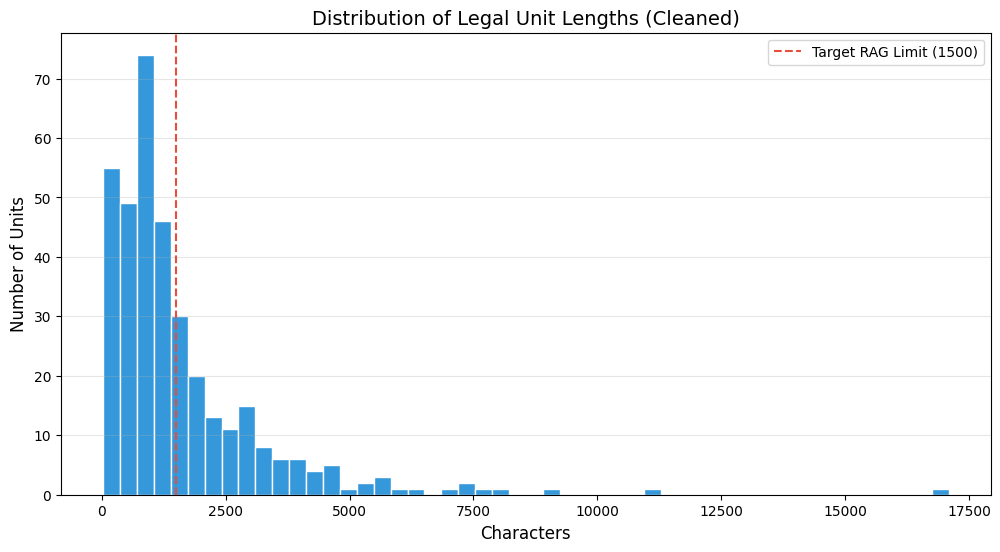

In [16]:
plt.figure(figsize=(12, 6))
plt.hist(df_units['len'], bins=50, color='#3498db', edgecolor='white')
plt.axvline(1500, color='#e74c3c', linestyle='--', label='Target RAG Limit (1500)')
plt.title('Distribution of Legal Unit Lengths (Cleaned)', fontsize=14)
plt.xlabel('Characters', fontsize=12)
plt.ylabel('Number of Units', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

LangChain's RecursiveCharacterTextSplitter breaks the long units into smaller pieces, and then use FAISS and Google Generative AI Embeddings to build your vector database.

In [17]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# 1500 chars with 200 overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
    length_function=len,
    separators=["\n\n", "\n", ".", " ", ""]
)

final_documents = []

for _, row in df_units.iterrows():
    unit_id = row['id']
    category = row['category']
    text = row['text']

    chunks = text_splitter.split_text(text)

    for i, chunk in enumerate(chunks):
        # We prepend the legal ID directly to the text (Contextual Chunking).
        # This prevents "orphan chunks" where the LLM gets a chunk of text
        # but has no idea which article it belongs to.
        enriched_content = f"[{unit_id}] {chunk}"

        doc = Document(
            page_content=enriched_content,
            metadata={
                "source": "EU_AI_Act_2024",
                "category": category,
                "legal_unit": unit_id,
                "chunk_index": i,
                "is_continuation": i > 0 # Helpful flag to know if this is the start of an article
            }
        )
        final_documents.append(doc)

print(f"Total vectorized chunks ready for FAISS: {len(final_documents)}")

Total vectorized chunks ready for FAISS: 619


In [18]:
# Inspect the first 3 chunks in the dataset
print("=== FIRST 3 CHUNKS IN THE DATASET ===\n")
for i in range(3):
    doc = final_documents[i]
    print(f"CHUNK {i+1}")
    print(f"Metadata: {doc.metadata}")
    print(f"Length: {len(doc.page_content)} characters")
    print(f"Text Preview: {doc.page_content[:500]}...\n")
    print("-" * 50 + "\n")

print("=== EXAMPLE OF A SPLIT UNIT (CHUNK INDEX > 0) ===\n")
for doc in final_documents:
    if doc.metadata.get("chunk_index") == 1: # This targets the second piece of a split unit
        print(f"Metadata: {doc.metadata}")
        print(f"Length: {len(doc.page_content)} characters")
        print(f"Text Preview: {doc.page_content[:800]}...\n")
        break

=== FIRST 3 CHUNKS IN THE DATASET ===

CHUNK 1
Metadata: {'source': 'EU_AI_Act_2024', 'category': 'RECITAL', 'legal_unit': 'RECITAL 1', 'chunk_index': 0, 'is_continuation': False}
Length: 992 characters
Text Preview: [RECITAL 1] The purpose of this Regulation is to improve the functioning of the internal market by laying down a uniform legal framework in particular for the development, the placing on the market, the putting into service and the use of artificial intelligence systems (AI systems) in the Union, in accordance with Union values, to promote the uptake of human centric and trustworthy artificial intelligence (AI) while ensuring a high level of protection of health, safety, fundamental rights as en...

--------------------------------------------------

CHUNK 2
Metadata: {'source': 'EU_AI_Act_2024', 'category': 'RECITAL', 'legal_unit': 'RECITAL 2', 'chunk_index': 0, 'is_continuation': False}
Length: 340 characters
Text Preview: [RECITAL 2] This Regulation should be applied in

During the data pre-processing phase of the EU AI Act, an additional refinement step was implemented to optimize the dataset for the Retrieval-Augmented Generation (RAG) architecture. Following the initial text splitting, a filtering mechanism was applied to remove 179 low-value, boilerplate chunks—specifically legislative preambles and fragmented text containing fewer than 100 characters. Additionally, leading punctuation artifacts generated by the recursive splitting process were stripped. This targeted reduction from 979 to 800 highly concentrated text chunks ensures the FAISS vector database is populated exclusively with semantically dense legal provisions. By eliminating contextual noise, this approach maximizes embedding precision, reduces retrieval latency, and mitigates the risk of Large Language Model (LLM) hallucinations during the generation phase

In [19]:
polished_documents = []

for doc in final_documents:
    # Strip away leading commas, periods, and whitespace
    clean_text = doc.page_content.lstrip(" ,.")


    if len(clean_text) > 100:
        # Update the document with the cleaned text
        doc.page_content = clean_text
        polished_documents.append(doc)

print(f"Original chunks: {len(final_documents)}")
print(f"Polished chunks ready for vectorization: {len(polished_documents)}")
print(f"Removed {len(final_documents) - len(polished_documents)} low-value/boilerplate chunks.")

Original chunks: 619
Polished chunks ready for vectorization: 607
Removed 12 low-value/boilerplate chunks.


In [20]:
# Inspect the first 3 polished chunks
print("=== FIRST 3 HIGH-QUALITY CHUNKS ===\n")
for i in range(3):
    doc = polished_documents[i]
    print(f"CHUNK {i+1}")
    print(f"Metadata: {doc.metadata}")
    print(f"Length: {len(doc.page_content)} characters")
    print(f"Text Preview: {doc.page_content[:500]}...\n")
    print("-" * 50 + "\n")

# Inspect a random chunk from the middle of the dataset
print("=== RANDOM CHUNK FROM THE MIDDLE ===\n")
random_idx = random.randint(10, len(polished_documents) - 1)
doc = polished_documents[random_idx]

print(f"Metadata: {doc.metadata}")
print(f"Length: {len(doc.page_content)} characters")
print(f"Text Preview: {doc.page_content[:800]}...\n")

=== FIRST 3 HIGH-QUALITY CHUNKS ===

CHUNK 1
Metadata: {'source': 'EU_AI_Act_2024', 'category': 'RECITAL', 'legal_unit': 'RECITAL 1', 'chunk_index': 0, 'is_continuation': False}
Length: 992 characters
Text Preview: [RECITAL 1] The purpose of this Regulation is to improve the functioning of the internal market by laying down a uniform legal framework in particular for the development, the placing on the market, the putting into service and the use of artificial intelligence systems (AI systems) in the Union, in accordance with Union values, to promote the uptake of human centric and trustworthy artificial intelligence (AI) while ensuring a high level of protection of health, safety, fundamental rights as en...

--------------------------------------------------

CHUNK 2
Metadata: {'source': 'EU_AI_Act_2024', 'category': 'RECITAL', 'legal_unit': 'RECITAL 2', 'chunk_index': 0, 'is_continuation': False}
Length: 340 characters
Text Preview: [RECITAL 2] This Regulation should be applied in a

**PUSH**

In [21]:
# for pushing
!git add .
!git commit -m "env created"
!git push -u origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Branch 'main' set up to track remote branch 'main' from 'origin'.
Everything up-to-date
